<a href="https://colab.research.google.com/github/azzy13/gnn_study/blob/main/GNN_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch

!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git
import random
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import model_selection, metrics, preprocessing
import copy
from torch_geometric.utils import degree

import torch
from torch import nn, optim, Tensor

from torch_sparse import SparseTensor, matmul

from torch_geometric.utils import structured_negative_sampling
from torch_geometric.data import download_url, extract_zip
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.typing import Adj

Looking in links: https://data.pyg.org/whl/torch-2.2.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 26.5 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.2.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 35.6 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.2.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 37.0 MB/s eta 0:00:00
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-fp6qtsfy
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-fp6qtsfy
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit e9648df16dcb6dde0e09b5736b1b2da5d68db2ad
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.6.0-py3-none-any.whl size=11

In [ ]:
url = 'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
extract_zip(download_url(url, '.'), '.')

movie_path = './ml-latest-small/movies.csv'
rating_path = './ml-latest-small/ratings.csv'
user_path = './ml-latest-small/users.csv'

Extracting ./ml-latest-small.zip


In [ ]:
rating_df = pd.read_csv(rating_path)

print(rating_df.head())

print(len(rating_df['movieId'].unique()))
print(len(rating_df['userId'].unique()))

rating_df.describe()


   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
9724
610


,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [ ]:
# perform encoding preprocessing to ensure that user_id and item_id are both
# in the range of [0, unique_count] so it won't cause out of bound issue when indexing embeddings
lbl_user = preprocessing.LabelEncoder()
lbl_movie = preprocessing.LabelEncoder()

rating_df.userId = lbl_user.fit_transform(rating_df.userId.values)
rating_df.movieId = lbl_movie.fit_transform(rating_df.movieId.values)

print(rating_df.userId.max())
print(rating_df.movieId.max())

609
9723


In [ ]:
rating_df.rating.value_counts()

rating
4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: count, dtype: int64

In [ ]:
# helper function which gets edge indices
def load_edge_csv(df,
                  src_index_col,
                  dst_index_col,
                  link_index_col,
                  rating_threshold=4):

    edge_index = None

    # Constructing COO format edge_index from input rating events

    # get user_ids from rating events in the order of occurance
    src = [user_id for user_id in  df['userId']]
    # get movie_id from rating events in the order of occurance
    dst = [(movie_id) for movie_id in df['movieId']]

    # apply rating threshold
    edge_attr = torch.from_numpy(df[link_index_col].values).view(-1, 1).to(torch.long) >= rating_threshold

    edge_index = [[], []]
    for i in range(edge_attr.shape[0]):
        if edge_attr[i]:
            edge_index[0].append(src[i])
            edge_index[1].append(dst[i])
    return edge_index

In [ ]:
edge_index = load_edge_csv(
    rating_df,
    src_index_col='userId',
    dst_index_col='movieId',
    link_index_col='rating',
    rating_threshold=4,
)

print(f"{len(edge_index)} x {len(edge_index[0])}")


2 x 48580


In [ ]:
# Convert to tensor
# Use LongTensor here because the .propagate() method in the model needs either LongTensor or SparseTensor
edge_index = torch.LongTensor(edge_index)
print(edge_index)
print(edge_index.size())

tensor([[   0,    0,    0,  ...,  609,  609,  609],
        [   0,    2,    5,  ..., 9443, 9444, 9445]])
torch.Size([2, 48580])


In [ ]:
#storing globally
num_users = len(rating_df['userId'].unique())
num_movies = len(rating_df['movieId'].unique())

In [ ]:
num_interactions = edge_index.shape[1]

# split the edges of the graph using a 80/10/10 train/validation/test split
all_indices = [i for i in range(num_interactions)]

train_indices, test_indices = train_test_split(all_indices,
                                               test_size=0.2,
                                               random_state=1)

val_indices, test_indices = train_test_split(test_indices,
                                             test_size=0.5,
                                             random_state=1)

train_edge_index = edge_index[:, train_indices]
val_edge_index = edge_index[:, val_indices]
test_edge_index = edge_index[:, test_indices]

In [ ]:
print(f"num_users {num_users}, num_movies {num_movies}, num_interactions {num_interactions}")
print(f"train_edge_index {train_edge_index}")
print((num_users + num_movies))
print(torch.unique(train_edge_index[0]).size())
print(torch.unique(train_edge_index[1]).size())


num_users 610, num_movies 9724, num_interactions 48580
train_edge_index tensor([[ 605,  110,  442,  ...,   65,  161,  427],
        [1110, 9619, 1283,  ..., 4640,  443,  827]])
10334
torch.Size([609])
torch.Size([5676])


In [ ]:
# helper function
def convert_r_mat_edge_index_to_adj_mat_edge_index(input_edge_index):
    R = torch.zeros((num_users, num_movies))
    for i in range(len(input_edge_index[0])):
        row_idx = input_edge_index[0][i]
        col_idx = input_edge_index[1][i]
        R[row_idx][col_idx] = 1

    R_transpose = torch.transpose(R, 0, 1)
    adj_mat = torch.zeros((num_users + num_movies , num_users + num_movies))
    adj_mat[: num_users, num_users :] = R.clone()
    adj_mat[num_users :, : num_users] = R_transpose.clone()
    adj_mat_coo = adj_mat.to_sparse_coo()
    adj_mat_coo = adj_mat_coo.indices()
    return adj_mat_coo

In [ ]:
# helper function
def convert_adj_mat_edge_index_to_r_mat_edge_index(input_edge_index):
    sparse_input_edge_index = SparseTensor(row=input_edge_index[0],
                                           col=input_edge_index[1],
                                           sparse_sizes=((num_users + num_movies), num_users + num_movies))
    adj_mat = sparse_input_edge_index.to_dense()
    interact_mat = adj_mat[: num_users, num_users :]
    r_mat_edge_index = interact_mat.to_sparse_coo().indices()
    return r_mat_edge_index

In [ ]:
# convert from r_mat (interaction matrix) edge index to adjescency matrix's edge index
train_edge_index = convert_r_mat_edge_index_to_adj_mat_edge_index(train_edge_index)
val_edge_index = convert_r_mat_edge_index_to_adj_mat_edge_index(val_edge_index)
test_edge_index = convert_r_mat_edge_index_to_adj_mat_edge_index(test_edge_index)

In [ ]:
print(train_edge_index)
print(train_edge_index.size())
print(val_edge_index)
print(val_edge_index.size())
print(test_edge_index)
print(test_edge_index.size())

tensor([[    0,     0,     0,  ..., 10326, 10327, 10333],
        [  610,   612,   653,  ...,   183,   183,   330]])
torch.Size([2, 77728])
tensor([[    0,     0,     0,  ..., 10226, 10236, 10240],
        [  615,   794,  2010,  ...,   317,   204,   413]])
torch.Size([2, 9716])
tensor([[    0,     0,     0,  ..., 10301, 10302, 10329],
        [  811,  1086,  1095,  ...,   585,   585,   183]])
torch.Size([2, 9716])


In [ ]:
# helper function for computing BPR loss
def sample_mini_batch(batch_size, edge_index):

    edges = structured_negative_sampling(edge_index)

    edges = torch.stack(edges, dim=0)

    indices = random.choices([i for i in range(edges[0].shape[0])], k=batch_size)

    batch = edges[:, indices]

    user_indices, pos_item_indices, neg_item_indices = batch[0], batch[1], batch[2]
    return user_indices, pos_item_indices, neg_item_indices

In [ ]:
# defines LightGCN model
class LightGCN(MessagePassing):

    def __init__(self, num_users,
                 num_items,
                 embedding_dim=64, # define the embding vector length for each node
                 K=3,
                 add_self_loops=False):

        super().__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim
        self.K = K
        self.add_self_loops = add_self_loops

        # define user and item embedding for direct look up.
        # embedding dimension: num_user/num_item x embedding_dim

        self.users_emb = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.embedding_dim) # e_u^0

        self.items_emb = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.embedding_dim) # e_i^0

        nn.init.normal_(self.users_emb.weight, std=0.1)
        nn.init.normal_(self.items_emb.weight, std=0.1)

    def forward(self, edge_index: Tensor):
        edge_index_norm = gcn_norm(edge_index=edge_index,
                                   add_self_loops=self.add_self_loops)

        emb_0 = torch.cat([self.users_emb.weight, self.items_emb.weight]) # E^0

        embs = [emb_0] # save the layer0 emb to the embs list

        emb_k = emb_0

        for i in range(self.K):
            emb_k = self.propagate(edge_index=edge_index_norm[0], x=emb_k, norm=edge_index_norm[1])
            embs.append(emb_k)

        embs = torch.stack(embs, dim=1)

        emb_final = torch.mean(embs, dim=1)

        users_emb_final, items_emb_final = torch.split(emb_final, [self.num_users, self.num_items])

        return users_emb_final, self.users_emb.weight, items_emb_final, self.items_emb.weight

    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j

layers = 3
model = LightGCN(num_users=num_users,
                 num_items=num_movies,
                 K=layers)

In [ ]:
def bpr_loss(users_emb_final,
             users_emb_0,
             pos_items_emb_final,
             pos_items_emb_0,
             neg_items_emb_final,
             neg_items_emb_0,
             lambda_val):

    reg_loss = lambda_val * (users_emb_0.norm(2).pow(2) +
                             pos_items_emb_0.norm(2).pow(2) +
                             neg_items_emb_0.norm(2).pow(2))

    pos_scores = torch.mul(users_emb_final, pos_items_emb_final)
    pos_scores = torch.sum(pos_scores, dim=-1) # positive samples
    neg_scores = torch.mul(users_emb_final, neg_items_emb_final)
    neg_scores = torch.sum(neg_scores, dim=-1) # negative samples


    bpr_loss = -torch.mean(torch.nn.functional.softplus(pos_scores - neg_scores))

    loss = bpr_loss + reg_loss

    return loss

In [ ]:
def get_user_positive_items(edge_index):
    user_pos_items = {}

    for i in range(edge_index.shape[1]):
        user = edge_index[0][i].item()
        item = edge_index[1][i].item()

        if user not in user_pos_items:
            user_pos_items[user] = []

        user_pos_items[user].append(item)

    return user_pos_items

In [ ]:
# compute recall@K and precision@K
def RecallPrecision_ATk(groundTruth, r, k):

    num_correct_pred = torch.sum(r, dim=-1)

    user_num_liked = torch.Tensor([len(groundTruth[i]) for i in range(len(groundTruth))])

    recall = torch.mean(num_correct_pred / user_num_liked)
    precision = torch.mean(num_correct_pred) / k
    return recall.item(), precision.item()

In [ ]:
# computes NDCG@K
def NDCGatK_r(groundTruth, r, k):
    assert len(r) == len(groundTruth)

    test_matrix = torch.zeros((len(r), k))

    for i, items in enumerate(groundTruth):
        length = min(len(items), k)
        test_matrix[i, :length] = 1
    max_r = test_matrix
    idcg = torch.sum(max_r * 1. / torch.log2(torch.arange(2, k + 2)), axis=1)
    dcg = r * (1. / torch.log2(torch.arange(2, k + 2)))
    dcg = torch.sum(dcg, axis=1)
    idcg[idcg == 0.] = 1.
    ndcg = dcg / idcg
    ndcg[torch.isnan(ndcg)] = 0.
    return torch.mean(ndcg).item()

In [ ]:
# wrapper function to get evaluation metrics
def get_metrics(model,
                input_edge_index, # adj_mat based edge index
                input_exclude_edge_indices, # adj_mat based exclude edge index
                k):

    user_embedding = model.users_emb.weight
    item_embedding = model.items_emb.weight

    edge_index = convert_adj_mat_edge_index_to_r_mat_edge_index(input_edge_index)

    exclude_edge_indices = [convert_adj_mat_edge_index_to_r_mat_edge_index(exclude_edge_index) \
                                      for exclude_edge_index in input_exclude_edge_indices]

    r_mat_rating = torch.matmul(user_embedding, item_embedding.T)

    rating = r_mat_rating

    for exclude_edge_index in exclude_edge_indices:
        user_pos_items = get_user_positive_items(exclude_edge_index)

        exclude_users = []
        exclude_items = []
        for user, items in user_pos_items.items():
            exclude_users.extend([user] * len(items))
            exclude_items.extend(items)

        rating[exclude_users, exclude_items] = -(1 << 10)

    # top k recommended items for each user
    _, top_K_items = torch.topk(rating, k=k)

    users = edge_index[0].unique()

    test_user_pos_items = get_user_positive_items(edge_index)

    test_user_pos_items_list = [test_user_pos_items[user.item()] for user in users]

    r = []
    for user in users:
        user_true_relevant_item = test_user_pos_items[user.item()]
        label = list(map(lambda x: x in user_true_relevant_item, top_K_items[user]))
        r.append(label)

    r = torch.Tensor(np.array(r).astype('float'))

    recall, precision = RecallPrecision_ATk(test_user_pos_items_list, r, k)
    ndcg = NDCGatK_r(test_user_pos_items_list, r, k)

    return recall, precision, ndcg

In [ ]:
# evaluate model
def evaluation(model,
               edge_index,
               exclude_edge_indices,
               k,
               lambda_val
              ):

    # embeddings
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(edge_index)

    r_mat_edge_index = convert_adj_mat_edge_index_to_r_mat_edge_index(edge_index)

    edges = structured_negative_sampling(r_mat_edge_index, contains_neg_self_loops=False)

    user_indices, pos_item_indices, neg_item_indices = edges[0], edges[1], edges[2]

    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]

    pos_items_emb_final, pos_items_emb_0 = items_emb_final[pos_item_indices], items_emb_0[pos_item_indices]

    neg_items_emb_final, neg_items_emb_0 = items_emb_final[neg_item_indices], items_emb_0[neg_item_indices]

    loss = bpr_loss(users_emb_final,
                    users_emb_0,
                    pos_items_emb_final,
                    pos_items_emb_0,
                    neg_items_emb_final,
                    neg_items_emb_0,
                    lambda_val).item()


    recall, precision, ndcg = get_metrics(model,
                                          edge_index,
                                          exclude_edge_indices,
                                          k)

    return loss, recall, precision, ndcg

In [ ]:
ITERATIONS = 10000
EPOCHS = 10
BATCH_SIZE = 1024
LR = 1e-3
ITERS_PER_EVAL = 200
ITERS_PER_LR_DECAY = 200
K = 20
LAMBDA = 1e-6

In [ ]:
# Training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device {device}.")


model = model.to(device)
model.train()

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
val_edge_index = val_edge_index.to(device)

Using device cpu.


In [ ]:
def get_embs_for_bpr(model, input_edge_index):
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(input_edge_index)


    edge_index_to_use = convert_adj_mat_edge_index_to_r_mat_edge_index(input_edge_index)

    user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(BATCH_SIZE, edge_index_to_use)

    user_indices, pos_item_indices, neg_item_indices = user_indices.to(device), pos_item_indices.to(device), neg_item_indices.to(device)

    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[pos_item_indices], items_emb_0[pos_item_indices]
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[neg_item_indices], items_emb_0[neg_item_indices]

    return users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0, neg_items_emb_final, neg_items_emb_0

In [28]:
# training
train_losses = []
val_losses = []
val_recall_at_ks = []

for iter in tqdm(range(ITERATIONS)):
    # forward prop
    users_emb_final, users_emb_0,  pos_items_emb_final, pos_items_emb_0, neg_items_emb_final, neg_items_emb_0 \
                = get_embs_for_bpr(model, train_edge_index)

    # loss
    train_loss = bpr_loss(users_emb_final,
                          users_emb_0,
                          pos_items_emb_final,
                          pos_items_emb_0,
                          neg_items_emb_final,
                          neg_items_emb_0,
                          LAMBDA)

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # validation set
    if iter % ITERS_PER_EVAL == 0:
        model.eval()

        with torch.no_grad():
            val_loss, recall, precision, ndcg = evaluation(model,
                                                           val_edge_index,
                                                           [train_edge_index],
                                                           K,
                                                           LAMBDA
                                                          )

            print(f"[Iteration {iter}/{ITERATIONS}] train_loss: {round(train_loss.item(), 5)}, val_loss: {round(val_loss, 5)}, val_recall@{K}: {round(recall, 5)}, val_precision@{K}: {round(precision, 5)}, val_ndcg@{K}: {round(ndcg, 5)}")

            train_losses.append(train_loss.item())
            val_losses.append(val_loss)
            val_recall_at_ks.append(round(recall, 5))
        model.train()

    if iter % ITERS_PER_LR_DECAY == 0 and iter != 0:
        scheduler.step()

  0%|          | 0/10000 [00:00<?, ?it/s]

[Iteration 0/10000] train_loss: -0.69292, val_loss: -0.69927, val_recall@20: 0.00059, val_precision@20: 0.00054, val_ndcg@20: 0.00059
[Iteration 200/10000] train_loss: -6.94204, val_loss: -5.1748, val_recall@20: 0.05612, val_precision@20: 0.02025, val_ndcg@20: 0.03698
[Iteration 400/10000] train_loss: -28.6017, val_loss: -21.37259, val_recall@20: 0.07103, val_precision@20: 0.02613, val_ndcg@20: 0.05491
[Iteration 600/10000] train_loss: -64.15594, val_loss: -45.26076, val_recall@20: 0.09052, val_precision@20: 0.03038, val_ndcg@20: 0.06328
[Iteration 800/10000] train_loss: -98.52845, val_loss: -74.85873, val_recall@20: 0.10938, val_precision@20: 0.03472, val_ndcg@20: 0.07413
[Iteration 1000/10000] train_loss: -143.17484, val_loss: -108.62749, val_recall@20: 0.11466, val_precision@20: 0.03608, val_ndcg@20: 0.07457
[Iteration 1200/10000] train_loss: -200.27458, val_loss: -144.19098, val_recall@20: 0.11611, val_precision@20: 0.03635, val_ndcg@20: 0.07855
[Iteration 1400/10000] train_loss: -

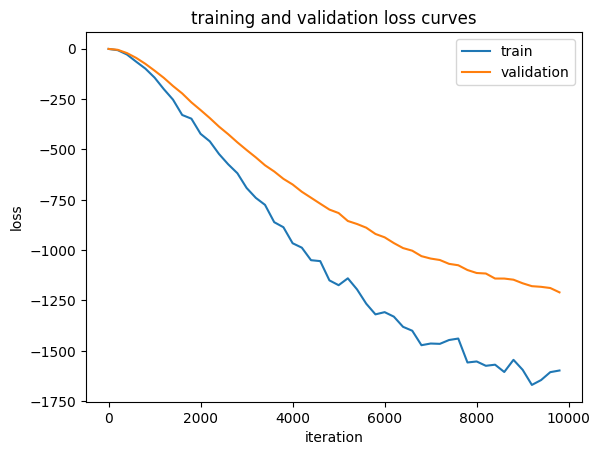

In [29]:
iters = [iter * ITERS_PER_EVAL for iter in range(len(train_losses))]
plt.plot(iters, train_losses, label='train')
plt.plot(iters, val_losses, label='validation')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('training and validation loss curves')
plt.legend()
plt.show()

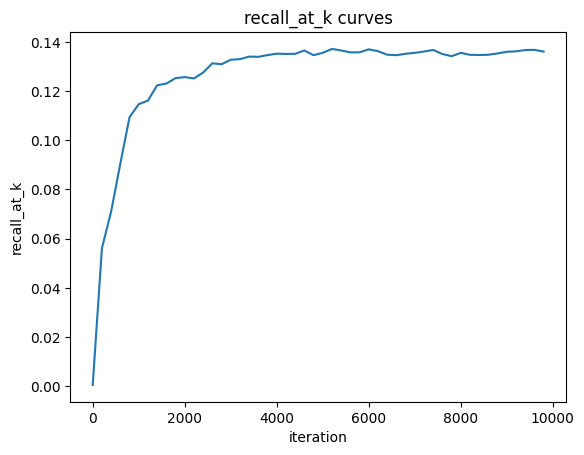

In [30]:
f2 = plt.figure()
plt.plot(iters, val_recall_at_ks, label='recall_at_k')
plt.xlabel('iteration')
plt.ylabel('recall_at_k')
plt.title('recall_at_k curves')
plt.show()

In [31]:
# test set
model.eval()
test_edge_index = test_edge_index.to(device)

test_loss, test_recall, test_precision, test_ndcg = evaluation(model,
                                                               test_edge_index,
                                                               [train_edge_index, val_edge_index],
                                                               K,
                                                               LAMBDA
                                                              )

print(f"[test_loss: {round(test_loss, 5)}, test_recall@{K}: {round(test_recall, 5)}, test_precision@{K}: {round(test_precision, 5)}, test_ndcg@{K}: {round(test_ndcg, 5)}")

[test_loss: -1218.17053, test_recall@20: 0.11948, test_precision@20: 0.04312, test_ndcg@20: 0.09174
